In [1]:
import pandas as pd 
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date, timedelta
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# UK House Prices 
By Rob Winter, 24/10/2022

## Introduction

Across the UK, first time buyers have seen houses become further and further out of reach, despite incetntives such as Help To Buy and Lifetime ISA's and no stamp duty for first time buyers (up to a £425k). 

I’ve used UK housing in the county of Somerset and whole UK economic data spanning 20+ years, covering over 215,000 house sales to try and find optimum times for prospective buyers to get on the housing ladder. 

### Reasons for un-attainable house prices

It's been suggested that this has been driven by multiple factors which include:
- Low interest rates
- Low housing supply
- Low unemployment
- House prices rising faster than wage growth.


### First time buyer questions to answer 
The following project aims to answer questions in relation to first time buyers problems. They are as follows:

- Are the traditional big factors actually true?
- When’s the best time to buy based on the ECONOMY?
- When’s the best time to buy based on the TIME OF YEAR?
- Can we predict house prices given all this data?

### Contents 
1. [Read in data and initial clean](#readdata)
2. [View data](#viewdata)
3. [Clean data](#cleandata)
4. [Merge data](#mergedata)
5. [Final dataset](#finaldataset)
6. [Analysis](#analysis)
7. [Question 1 - Are the traditional big factors actually true?](#q1)
8. [Question 2 - When’s the best time to buy based on the ECONOMY?](#q2)
9. [Question 3 - When’s the best time to buy based on the TIME OF YEAR?](#q3)
10. [Question 4 - Can we predict house prices given all this data?](#q4)


In [2]:
# Function to do an initial clean of the csv data files we're importing 
def clean_data(csv_file, date_name='Date'):
    '''
    INPUTS
    csv_file - comma separated value file holding the data
    date_name - the column name of the date data
    
    OUTPUTS
    df - cleaned pandas data frame that has re-named, re-fromatted and sorted date column 
    '''
    
    # Read Data 
    df = pd.read_csv(csv_file)
    
    # Re-name Date
    df = df.rename(columns={date_name: 'Date'})
    
    # Re-format Date 
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort on Date 
    df = df.sort_values(by='Date')
    return df 

## Read in data and initial clean <a name="readdata"></a>


We first need to read in the data that we plan to use. These data sets are as follows:

- **UK Interest Rate data** <i>(from 1975 to 2022)</i>. **Source**: https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp#
- **UK Individual House Sales Data** <i>(from 1995 to 2017)</i>. **Source**: https://landregistry.data.gov.uk/app/ppd
- **UK Unemployment Data** <i>(from 1971 to 2022)</i>. **Source**: https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms
- **UK GDP Data** <i>(from 1997 to 2022)</i>. **Source**: https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/monthlygrossdomesticproductbygrossvalueadded
- **UK New Build House Data** <i>(from 1995 to 2015)</i>. **Source**: https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/numberofresidentialpropertysalesforsubnationalgeographiesnewlybuiltdwellingshpssadataset22

Contains HM Land Registry data © Crown copyright and database right 2021. This data is licensed under the Open Government Licence v3.0.

In [3]:
# Extract data needed for analysis

# BOE Interest rate data
interest_rate_df = clean_data(r'..\01_Data\int_rate.csv', 'Date Changed')

# Individual sales data - Core dataset 
individual_house_prices_df = clean_data(r'..\01_Data\price_paid_records.csv', 'Date of Transfer')

# Unemployment Data
unemployment_df = clean_data(r'..\01_Data\unemployment.csv')

# Unemployment Data
gdp_df = clean_data(r'..\01_Data\gdp_data.csv')

# NewBuilds Data
new_build_df = clean_data(r'..\01_Data\NewBuilds.csv')

In [4]:
# Unemployment Data, this data is optional but I've left it out as it dodn't offer much insight what I was looking at 
# wage_df = clean_data(r'..\01_Data\WageGrowth.csv')

## View the data <a name="viewdata"></a>

In [5]:
interest_rate_df.head()

,Date,Rate
244,1975-01-20,11.25
243,1975-01-27,11.00
242,1975-02-10,10.75
241,1975-02-17,10.50
240,1975-03-10,10.25


In [6]:
unemployment_df.head()

,Date,UnemploymentRate
0,1971-02-01,3.8
1,1971-03-01,3.9
2,1971-04-01,4.0
3,1971-05-01,4.1
4,1971-06-01,4.1


In [7]:
gdp_df.head()

,Date,GDP
0,1997-01-01,1.07
1,1997-02-01,1.43
2,1997-03-01,0.24
3,1997-04-01,0.38
4,1997-05-01,-0.67


In [8]:
individual_house_prices_df.head()

,Transaction unique identifier,Price,Date,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
260296,{CDFEF02F-BB0B-4C64-AD05-58B3DD57ED48},53250,1995-01-01,S,N,L,MANCHESTER,ROCHDALE,GREATER MANCHESTER,A,A
648744,{1F6B59A3-72E9-4E4A-9EB7-E073108E5F0E},29500,1995-01-01,S,Y,L,RAYLEIGH,ROCHFORD,ESSEX,A,A
159007,{03849A0F-DB07-4528-85D3-89EC8FFF1E1A},49000,1995-01-01,D,N,F,BRISTOL,BRISTOL,AVON,A,A
146455,{891F7B57-80C4-4BAA-83A8-BAE12D824A6E},35000,1995-01-01,D,N,F,STOURBRIDGE,DUDLEY,WEST MIDLANDS,A,A
444544,{4268D6A8-E78B-4E33-8B88-34A8D5CB7075},128000,1995-01-01,T,N,F,ILFORD,REDBRIDGE,GREATER LONDON,A,A


In [9]:
new_build_df.head()

,Date,NewAll,NewDetached,NewSemi,NewTerraced,NewFlat
0,1995-12-01,107519,46087,24322,18071,19039
1,1996-03-01,107019,46437,23742,17940,18900
2,1996-06-01,107980,47899,23615,17843,18623
3,1996-09-01,111024,50271,23705,17971,19077
4,1996-12-01,116088,53101,24349,18849,19789


In [10]:
#wage_df.head(-5)

## Data Cleaning <a name="cleandata"></a>

### Interest Rate Data

The current interest rate data is not very useful due to the fact it has sporadically date indexed rows (whereas other datasets have daily updates).

Take a look at the interest rate table and graph below before we start filling in the data. In practice, interest rates remain the same until they changed by the Bank of England. You'll notice for the dataset the interest rate starts decreasing/increasing as soon as it reaches the next new interest rate (which doesn't happen in practice).

In [11]:
interest_rate_df.head()

,Date,Rate
244,1975-01-20,11.25
243,1975-01-27,11.00
242,1975-02-10,10.75
241,1975-02-17,10.50
240,1975-03-10,10.25


#### Original Sporadic Interest Data

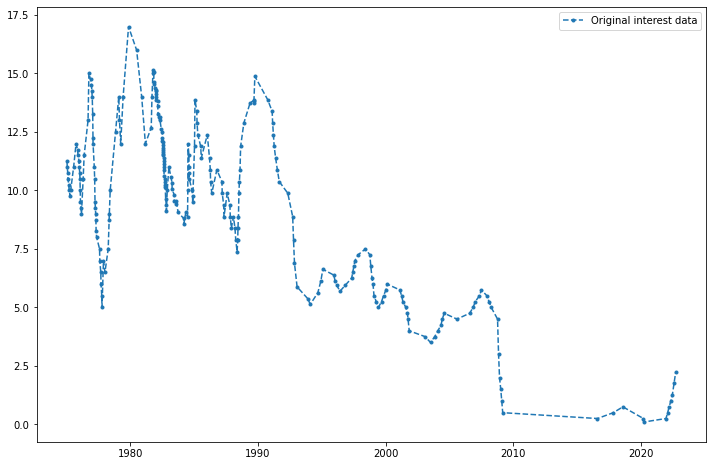

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(interest_rate_df.Date, interest_rate_df.Rate, label='Original interest data',linestyle='--', marker='.')

ax.legend()
plt.show()

### Filling in the missing data - fillna()

`fillna(method = 'ffill')` can be used to propagate last valid observation forward to next valid observation.

Forward fill is relevant as the interest rates are changed only when required by the Bank of England (BOE). Therefore, the `Rate` will stay the same as the previous day unless changed.

See the functions below which create a new dataframe with daily filled in dates and merge 2 dataframes on a particular column and fill missing values

In [13]:
def fill_dates(curr_df):
    ''' Function - Create a new dataframe with daily filled in dates
    
    Inputs
    curr_df - the reference dataframe from which the first and last date entries will be used to create a daily 
              dates column.
    
    Outputs
    df - A new data frame with 'Date' column with daily dates from specified date range
    '''
    
    # Create a new df 
    df = pd.DataFrame({'Date':[]})
    # Fill the date column with dates from the start of the time that data is available until end
    df['Date'] = pd.date_range(pd.to_datetime(curr_df.Date).min(),
                               pd.to_datetime(curr_df.Date).max()-timedelta(days=1),
                               freq='d')

    return df

def merge_n_fill(df1, df2, on_col, value_fill = None, how_fill = 'ffill'):
    '''Function - Merge 2 dataframes on a particular column and fill missing values
    
    Inputs 
    df1, df2  - Data frames with common columns that can be used to merge together
    on_col - The column(s) to merge the dataframes on 
    value_fill - Value to fill the missing data with (fNone is default)
    how_fill - Method to fill missing data with (ffill is default)''' 
    
    # Merge the old and new interest df's on the 'Date' column
    df = pd.merge(df1, df2[['Date', on_col]], on='Date', how='outer')

    #Fill in the missing rate data using how_fill method
    df = df.fillna(value = value_fill, method=how_fill)
    
    return df 

### Using the above functions

We can now use the `fill_dates()` function to create a new date column that has daily date indexes from he beginning to end of the data.

`merge_n_fill()` can then be used to `ffill` (forward fill) the values of other columns.



In [14]:
# ECONMIC DATA MERGE
# Fill missing dates between interest rate ammendments
filled_int_df = fill_dates(interest_rate_df)
filled_int_df = merge_n_fill(filled_int_df, interest_rate_df, 'Rate')

# Fill missing dates between gdp updates
filled_gdp_df = fill_dates(gdp_df)
filled_gdp_df = merge_n_fill(filled_gdp_df, gdp_df, 'GDP')

# Fill missing dates between unemployment updates
filled_unemployment_df = fill_dates(unemployment_df)
filled_unemployment_df = merge_n_fill(filled_unemployment_df, unemployment_df, 'UnemploymentRate')

# Fill missing dates between wage growth updates
# filled_wage_df = fill_dates(wage_df)
# filled_wage_df = merge_n_fill(filled_wage_df, wage_df, 'Wage_Growth')

#HOUSE SALES MERGE
# Fill missing dates between new house sales updates
tot_new_build_df = fill_dates(new_build_df)
tot_new_build_df = merge_n_fill(tot_new_build_df, new_build_df, 'NewAll')

# Fill missing dates between new DETACHED house sales updates
D_new_build_df = fill_dates(new_build_df)
D_new_build_df = merge_n_fill(D_new_build_df, new_build_df, 'NewDetached')
# Fill missing dates between new SEMI DETACHED house sales updates
S_new_build_df = fill_dates(new_build_df)
S_new_build_df = merge_n_fill(S_new_build_df, new_build_df, 'NewSemi')

# Fill missing dates between new TERRACED house sales updates
T_new_build_df = fill_dates(new_build_df)
T_new_build_df = merge_n_fill(T_new_build_df, new_build_df, 'NewTerraced')

# Fill missing dates between new FLAT house sales updates
F_new_build_df = fill_dates(new_build_df)
F_new_build_df = merge_n_fill(F_new_build_df, new_build_df, 'NewFlat')

#### Daily Interest Data and House Type Sales

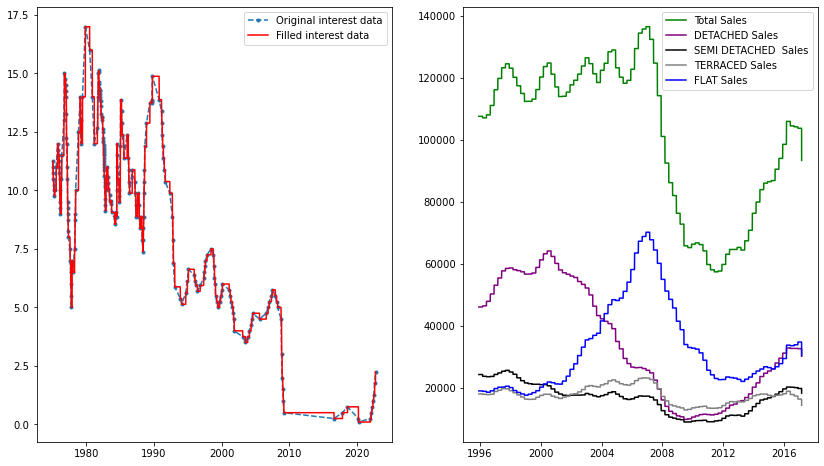

In [15]:
# Plot new data
fig, (ax,ax2) = plt.subplots(1,2,figsize=(14,8))

# Plot original interest rate
ax.plot(interest_rate_df.Date, interest_rate_df.Rate, label='Original interest data',linestyle='--',marker='.')
# Plot new interest rate
ax.plot(filled_int_df.Date, filled_int_df.Rate, label='Filled interest data', color='r')

# Plot Total House sales and all the specific house sales too (Detached, semi-detached, terraced, flats)
ax2.plot(tot_new_build_df.Date, tot_new_build_df.NewAll, color = 'g', label='Total Sales')
ax2.plot(tot_new_build_df.Date, D_new_build_df.NewDetached, color = 'purple', label='DETACHED Sales')
ax2.plot(tot_new_build_df.Date, S_new_build_df.NewSemi, color = 'k', label='SEMI DETACHED  Sales')
ax2.plot(tot_new_build_df.Date, T_new_build_df.NewTerraced, color = 'grey', label='TERRACED Sales')
ax2.plot(tot_new_build_df.Date, F_new_build_df.NewFlat, color = 'b', label='FLAT Sales')

ax.legend()
ax2.legend()
plt.show()

### Individual house price data

The following dataset contains the main housing data. It shows individual house sales along with property features and locations of the houses.

The peices of missing data that would be very valuable would be number of bedrooms or floorplan area. These would be very influential in the final sale price, but it will be seen if any useful outcomes can be deduced without this information.

In [16]:
# Preview created house price dataframe 
individual_house_prices_df.head()

,Transaction unique identifier,Price,Date,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
260296,{CDFEF02F-BB0B-4C64-AD05-58B3DD57ED48},53250,1995-01-01,S,N,L,MANCHESTER,ROCHDALE,GREATER MANCHESTER,A,A
648744,{1F6B59A3-72E9-4E4A-9EB7-E073108E5F0E},29500,1995-01-01,S,Y,L,RAYLEIGH,ROCHFORD,ESSEX,A,A
159007,{03849A0F-DB07-4528-85D3-89EC8FFF1E1A},49000,1995-01-01,D,N,F,BRISTOL,BRISTOL,AVON,A,A
146455,{891F7B57-80C4-4BAA-83A8-BAE12D824A6E},35000,1995-01-01,D,N,F,STOURBRIDGE,DUDLEY,WEST MIDLANDS,A,A
444544,{4268D6A8-E78B-4E33-8B88-34A8D5CB7075},128000,1995-01-01,T,N,F,ILFORD,REDBRIDGE,GREATER LONDON,A,A


Fortunately there are no 'Nan' values in any of the columns.

In [17]:
print("Total number of NaN's in columns\n")
for col in individual_house_prices_df.columns:
    num = individual_house_prices_df[individual_house_prices_df[['Date']].isna().any(1)].shape[0]
    print("%s - %d" %(col, num))

Total number of NaN's in columns

Transaction unique identifier - 0
Price - 0
Date - 0
Property Type - 0
Old/New - 0
Duration - 0
Town/City - 0
District - 0
County - 0
PPDCategory Type - 0
Record Status - monthly file only - 0


### Filtering and removing unnecessary data

The next step is to filter data we don't want and columns we don't need. 

As this study is predominantly looking at residential property, it was decided to filter out any PPDCategory that wasn't designated 'A'. On the **HM LAND REGISTRY** website, they highlight the difference between the categories:

- <i>'PPDCategory Type' Indicates the type of Price Paid transaction. <b>A = Standard Price Paid entry</b>, includes single residential property sold for full market value. <b>B = Additional Price Paid entry</b> including transfers under a power of sale/repossessions, buy-to-lets (where they can be identified by a Mortgage) and transfers to non-private individuals. Note that category B does not separately identify the transaction types stated. HM Land Registry has been collecting information on Category A transactions from January 1995. Category B transactions were identified from October 2013.</i>

Th following decisions were also made:

- **Filter on houses sold in the 'County' of SOMERSET** -> This was of personal interest to me as this is where I live and also helped reduce run time of some of data wrangling/cleaning stages.
- **Filter on houses with a sale price of £500k or less** -> This was predominantly done to whittle down houses that were likely to be bought by first time buyers (the focus of this project). It also was key in removing some of the 'long tailed' data points (ie. the minority of multi million £ houses).
- **Drop 'Transaction unique identifier' and 'Record Status - monthly file only'** -> Simply not required


We will remove the date column later too but it will be used to merge some of the other dataframes to this one.

In [18]:
# Clean the individual house price (ihp) dataframe.
def thorough_clean_ihp(df,county='SOMERSET', drop_cols=None):
    '''Function filter the dataframe given and then drop all cols the user desires
    
    Inputs
    df - Main dataframe to filter and drop columns from
    county - The county to filter properties on
    drop_cols - columns to drop from the dataframe
    
    Outputs
    cleaned_df - A clean and filtered dataframe based on county and dropped columns'''
    
    cleaned_df=df[(df['Record Status - monthly file only']=='A')&
          (df['Price']<5e5)&                           # Avg first time buyer < £500K
         (df['Property Type']!='O')&                   # Other type doesn't initially seem useful as I don't have sales data to match this
         (df['County']==county)]                       # Set as Somerset as default
    cleaned_df = cleaned_df.drop(drop_cols, axis=1)
    return cleaned_df

clean_ihp_df = thorough_clean_ihp(individual_house_prices_df, 'SOMERSET', ['Transaction unique identifier',
                                                                          'PPDCategory Type',
                                                                          'Record Status - monthly file only',
                                                                           'District',
                                                              ])

In [19]:
clean_ihp_df.head()

,Price,Date,Property Type,Old/New,Duration,Town/City,County
11624,24750,1995-01-02,S,N,F,TAUNTON,SOMERSET
650164,80000,1995-01-03,D,N,F,GLASTONBURY,SOMERSET
664063,86750,1995-01-03,T,N,F,FROME,SOMERSET
561776,57000,1995-01-03,S,N,F,TAUNTON,SOMERSET
458336,45000,1995-01-03,T,N,F,CHARD,SOMERSET


In [20]:
def merged_house_types_sales(original_df, house_df, house_type):
    '''Function to merge the house type sales to the original database
    
    Inputs
    original_df - Main dataframe created so far (must have at least 'Date' and 'Property Type' columns)
    house_df - a dataframe that only contains houses of the same 'Property Type'. Must have columns 'Date' (daily intervals)
                and a monthly saleprice column for the given property type (output of merge_n_fill() function).
    house_type - 'D', 'S', 'T', 'F' The type of property
    
    Outputs
    temp_df - A df with 'Date' and monthly price for given property '''
    
    # Get house_df column name 
    h_col_name= house_df.columns[-1]
    
    # rename that column to PTypeSales
    house_df = house_df.rename(columns={h_col_name:'PTypeSales'})
    
    # Get house types of same kind into a temporary df
    temp_df = original_df[original_df['Property Type'] == house_type]
    
    # Drop the house type from the original df
    original_df = original_df[original_df['Property Type'] != house_type]
    
    # Merge the house types df with the 
    temp_df = house_df.merge(temp_df, on='Date', how='inner')
    
    # print(temp_df.head())
    return temp_df

In [21]:
#create a list of merged_house_types_sales() outputs
dfs=[]

# For each property type dataframe (eg. a dataframes with only 'Detached'/'D' type properties) 
# merge the house type sales to the clean_ihp_df dataframe
for house_df in [D_new_build_df,S_new_build_df,T_new_build_df,F_new_build_df]:

    if house_df.columns[-1]=='NewDetached':
        dfs.append(merged_house_types_sales(clean_ihp_df, house_df, 'D'))
    elif house_df.columns[-1]=='NewSemi':
        dfs.append(merged_house_types_sales(clean_ihp_df, house_df, 'S'))
    elif house_df.columns[-1]=='NewTerraced':
        dfs.append(merged_house_types_sales(clean_ihp_df, house_df, 'T'))
    elif house_df.columns[-1]=='NewFlat':
        dfs.append(merged_house_types_sales(clean_ihp_df, house_df, 'F'))
    else:
        next
    
    # Add all the dataframes together 
    final_df = pd.concat(dfs)

In [22]:
final_df.head()

,Date,PTypeSales,Price,Property Type,Old/New,Duration,Town/City,County
0,1995-12-01,46087.0,211500,D,N,F,WELLINGTON,SOMERSET
1,1995-12-01,46087.0,90000,D,N,F,YEOVIL,SOMERSET
2,1995-12-01,46087.0,85000,D,N,F,TAUNTON,SOMERSET
3,1995-12-01,46087.0,98000,D,N,F,TAUNTON,SOMERSET
4,1995-12-01,46087.0,97500,D,Y,F,BRIDGWATER,SOMERSET


## Merge the data together <a name="mergedata"></a>

Now that the data has been cleaned to the required standard, we can begin to merge the datasets together. All datasets will be merged onto the `clean_ihf_df` by using the `Date` column as the reference. 

All merges will be of type `inner` so that only areas where all data is available will be joined.

In [23]:
# Merge interest data into the individual house price data
merged_df = pd.merge(final_df, filled_int_df[['Date','Rate']], on='Date', how='inner')

# Merge wage growth data into the individual house price data
# merged_df = pd.merge(merged_df, filled_wage_df[['Date','Wage_Growth']], on='Date', how='inner')

# Merge GDP data into the new merged_df
merged_df = pd.merge(merged_df, filled_gdp_df[['Date','GDP']], on='Date', how='inner')

# Merge unemployment data into the new merged_df
merged_df = pd.merge(merged_df, filled_unemployment_df[['Date','UnemploymentRate']], on='Date', how='inner')

merged_df = merged_df.sort_values(by='Date')
merged_df = merged_df.rename(columns={'Rate':'Int_Rate'})

In [24]:
# Remove towns that don't have enough data
for town in merged_df['Town/City'].unique():
    if merged_df[merged_df['Town/City']==town].shape[0]<5:
        #print(town)
        merged_df = merged_df[merged_df['Town/City'].str.contains(town) == False]

## The Final Dataset <a name="finaldataset"></a>

In [25]:
merged_df.head()

,Date,PTypeSales,Price,Property Type,Old/New,Duration,Town/City,County,Int_Rate,GDP,UnemploymentRate
214919,1997-01-01,18849.0,31500,T,N,F,LANGPORT,SOMERSET,5.94,1.07,7.5
9,1997-01-02,19789.0,60000,F,N,L,TAUNTON,SOMERSET,5.94,1.07,7.5
8,1997-01-02,18849.0,27000,T,N,F,TAUNTON,SOMERSET,5.94,1.07,7.5
7,1997-01-02,18849.0,29245,T,N,F,BURNHAM-ON-SEA,SOMERSET,5.94,1.07,7.5
6,1997-01-02,18849.0,56000,T,N,F,TAUNTON,SOMERSET,5.94,1.07,7.5


## Analysis <a name="analysis"></a>

## Question 1 — Are the traditional big factors really true? <a name="q1"></a>

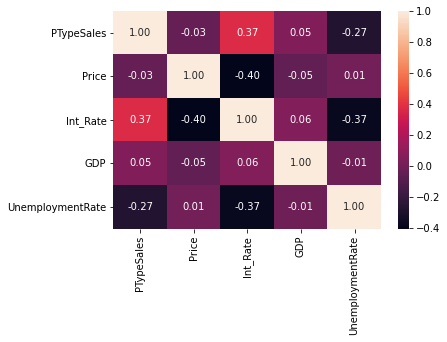

In [26]:
cat_df = merged_df.select_dtypes(include=['object']).copy()# Subset to a dataframe only holding the categorical columns
#Pull a list of the column names of the categorical variables
cat_cols = cat_df.columns

corr_df = merged_df.drop(cat_cols, axis =1)
sns.heatmap(corr_df.corr(), annot=True, fmt='.2f')

# PTypeSales / PTypePrice- Explain better  

From the coefficient plot above, the actual sale price of these properties was largely uncorrelated to any of the economic factors, with only interest rates showing any major correlation.

The interest rate’s negative correlation (-0.40) does tend to line up with the statements above where we expect lower rates to lead to higher sale prices.

One thing that could be noted is that `Int_Rate` are correlated to `PTypeSale` (Monthly sale of specific property type), which is then correlated to `UnemploymentRate`, which is then also correlated to `Int_Rate`, and thus correlated to `Price`. Can we therefore say that `PTypeSales` and `UnemploymentRate` are indirectly correlated to `Price`?

More data analyses can be found later on when we look at a Linear Model regression and the coefficients associated with it. See [here](#More)

## Question 2 — When’s the best time to buy based on the ECONOMY? <a name="q2"></a>

In [27]:
# Get average house price value by quarter
avg_house_df = merged_df.groupby('Date').mean().resample('QS').mean().reset_index()[['Date', 'Price', 'Int_Rate']]

In [28]:
# Get a dataframe that covers the financial crisis date period
f_crisis = avg_house_df[(avg_house_df.Date>datetime.strptime('2007/01/01', '%Y/%d/%M')) &
             (avg_house_df.Date<datetime.strptime('2010/01/01', '%Y/%d/%M'))]

# Show the difference between mean high and low house prices from the financial crisis
print('Change in mean house prices from peak to trough of 2 years between housing crisis: £%.2f' 
      %(f_crisis.Price.max()-f_crisis.Price.min()))

Change in mean house prices from peak to trough of 2 years between housing crisis: £35657.51


In [29]:
#What's the lowest interest rate over than time period?
f_crisis[f_crisis.Int_Rate==f_crisis.Int_Rate.min()].Int_Rate.unique()[0]

0.5

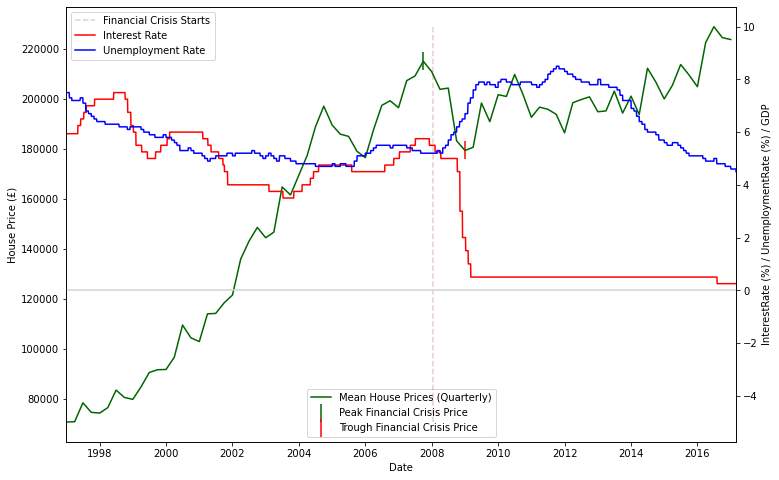

<Figure size 432x288 with 0 Axes>

In [30]:
# Plot the data we've collected so far

fig, ax1 = plt.subplots(figsize=(12,8))

ax2 = ax1.twinx()

datex = datetime.strptime('2008/15/9', '%Y/%d/%M')
ax2.plot([datex,datex], [-5,10], color='maroon', alpha=0.2, linestyle='--', label='Financial Crisis Starts')

peak = f_crisis[f_crisis.Price == f_crisis.Price.max()]
trough = f_crisis[f_crisis.Price == f_crisis.Price.min()]

ax1.scatter(peak.Date, peak.Price, color='darkgreen', marker='|', s=300, label='Peak Financial Crisis Price')
ax1.scatter(trough.Date, trough.Price, color='red', marker='|', s=300, label='Trough Financial Crisis Price')

#ax1.scatter(merged_df['Date'], merged_df['Price'], color='g', label='House Price')
ax1.plot(avg_house_df.Date, avg_house_df.Price, color='darkgreen', label='Mean House Prices (Quarterly)')

ax1.set_ylabel('House Price (£)')
#ax1.set_ylim(0,5e6)
ax1.legend(loc="lower center")

ax2.plot(merged_df['Date'], merged_df['Int_Rate'], color='r', label='Interest Rate')

ax2.plot(merged_df['Date'], merged_df['UnemploymentRate'], color='b', label='Unemployment Rate')

ax2.plot([merged_df['Date'].min(),merged_df['Date'].max()],[0,0], color='lightgrey')
# ax2.plot(merged_df['Date'], merged_df['Wage_Growth'], color='lightblue', label='Wage Growth')

ax2.set_ylabel('InterestRate (%) / UnemploymentRate (%) / GDP')
ax2.legend(loc="upper left")


ax1.set_xlim(merged_df['Date'].min(), merged_df['Date'].max())
# ax1.set_xlim(wage_df['Date'].min(), merged_df['Date'].max())
ax1.set_xlabel('Date')
plt.show()
plt.savefig('FinancialCrisis.png')

One thing that is interesting to note about the graph above is that during the start of 2008, the UK saw the beginning of the financial crisis. This lead the BOE to lower interest rates by over 5%. They did this in order to stimulate the economy and growth and combat the rise in unemployment that was brought on by the crisis. 

Lower interest rates stimulate the population to spend more and it also allows for lenders to hand out mortgages at lower rates. This in turn makes houses more affordable. With this increase in "supply" of "affordable" homes to buy, this may be a reason as to why the rate of change of mean house prices seems to shallow out.

## Question 3 - When’s the best time to buy based on the TIME OF YEAR? <a name="q3"></a>

In [31]:
def to_monthly(df):
    ''' Turn daily data times to monthly
    INPUT
    df - general dataframe that has a date column
    
    OUTPUT
    df - general df with daily Date column changed to monthly
    '''
    
    df['Date'] = df['Date'].dt.to_period('M')
    return df


def get_highlow_month(df, town):
    ''' Get the months for each town in the dataframe which have the highest and lowest sale prices.
    INPUT
    df - general dataframe 
    town - the town you want to check the high and low prices for
    
    OUTPUT
    low_month.iloc[0], hi_month.iloc[0] - The lowest and the highest price month 
    '''
    
    mnth_df = to_monthly(df.groupby(['Date', 'Town/City', 'Property Type']).mean().reset_index())
    mnth_df = mnth_df[mnth_df['Town/City']==town].reset_index()
    monthly = mnth_df.groupby(mnth_df['Date'].dt.strftime('%B'))['Price'].mean().reset_index()

    low_month = monthly[monthly.Price==monthly.Price.min()]
    hi_month = monthly[monthly.Price==monthly.Price.max()]
    
    return low_month.iloc[0], hi_month.iloc[0]

# get a dictionary with the high and low sales month of houses in Somerset
hi_low_dict = {}
for town in merged_df['Town/City'].unique():
    hi_low_dict[town] = get_highlow_month(clean_ihp_df, town)

In [32]:
# create 2 new dictionaries that will separate out the hi_low_dict
low_m_count={}
hi_m_count={}

# get counts of each month containing the highest or lowest price
for town in hi_low_dict.keys():
    
    # if the given month in the dictionary is already in the low_m_count (low month count) dict, 
    # then just add 1 to the counter
    if hi_low_dict[town][0][0]in low_m_count.keys():
        low_m_count[hi_low_dict[town][0][0]] += 1
    # Otherwise, initate the counter with a 1
    else:
        low_m_count[hi_low_dict[town][0][0]] = 1
    
    # if the given month in the dictionary is already in the hi_m_count (high month count) dict, 
    # then just add 1 to the counter
    if hi_low_dict[town][1][0] in hi_m_count.keys():
        hi_m_count[hi_low_dict[town][1][0]] += 1
    # Otherwise, initate the counter with a 1
    else:
        hi_m_count[hi_low_dict[town][1][0]] = 1

#Format the data in %B datetime convention
hi_fmted_data = sorted(hi_m_count.items(), key = lambda x:datetime.strptime(x[0], '%B'), reverse=False)
low_fmted_data = sorted(low_m_count.items(), key = lambda x:datetime.strptime(x[0], '%B'), reverse=False)

In [33]:
# create dataframes for dicts so they're easy to merge and sort
hi_df = pd.DataFrame(hi_fmted_data, columns=['Month', 'High'])
lo_df = pd.DataFrame(low_fmted_data, columns=['Month', 'Low'])

# merge and sort
hi_lo_df = hi_df.merge(lo_df, how='outer', on='Month').fillna(0)
hi_lo_df['Month'] = pd.to_datetime(hi_lo_df['Month'], format='%B')
hi_lo_df = hi_lo_df.sort_values(by='Month')
hi_lo_df['Month'] = hi_lo_df['Month'].dt.strftime('%B')

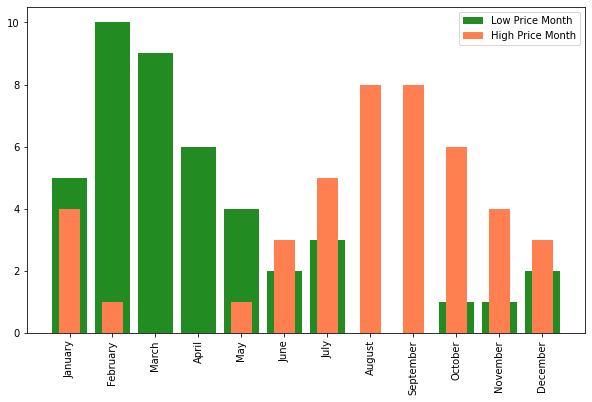

In [34]:
# plot df's
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(hi_lo_df.Month,hi_lo_df.Low, width =0.8, label='Low Price Month', color='forestgreen')
ax.bar(hi_lo_df.Month,hi_lo_df.High, width =0.5, label='High Price Month', color='coral')

plt.xticks(rotation=90)
plt.legend()
plt.show()

## Question 4 - Can we predict house prices given all this data? <a name="q4"></a>

In [35]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [36]:
# Check function works
dummy_df = create_dummy_df(merged_df, cat_cols, False)
dummy_df.head()

,Date,PTypeSales,Price,Int_Rate,GDP,UnemploymentRate,Property Type_F,Property Type_S,Property Type_T,Old/New_Y,...,Town/City_TIVERTON,Town/City_WATCHET,Town/City_WEDMORE,Town/City_WELLINGTON,Town/City_WELLS,Town/City_WESTBURY,Town/City_WESTON-SUPER-MARE,Town/City_WINCANTON,Town/City_WINSCOMBE,Town/City_YEOVIL
214919,1997-01-01,18849.0,31500,5.94,1.07,7.5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,1997-01-02,19789.0,60000,5.94,1.07,7.5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1997-01-02,18849.0,27000,5.94,1.07,7.5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,1997-01-02,18849.0,29245,5.94,1.07,7.5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1997-01-02,18849.0,56000,5.94,1.07,7.5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Drop unwanted columns 
model_df= merged_df.drop(['Date', 'County'], axis = 1)

In [38]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


In [39]:
#Test predicting individual house prices 
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(model_df, 'Price', cat_cols, False, test_size=.1, rand_state=42)

In [40]:
print("Train: %.4f\nTest: %.4f" %(train_score, test_score))

Train: 0.5070
Test: 0.5059


## More property type analysis <a name="More"></a>

In [41]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(10)

,est_int,coefs,abs_coefs
6,Property Type_T,-126844.773210,126844.773210
5,Property Type_S,-106819.957821,106819.957821
4,Property Type_F,-104126.400262,104126.400262
47,Town/City_WESTBURY,-61107.890684,61107.890684
12,Town/City_BRIDGWATER,-55132.454523,55132.454523
15,Town/City_BURNHAM-ON-SEA,-55026.605057,55026.605057
17,Town/City_CHARD,-52415.473036,52415.473036
43,Town/City_WATCHET,-50678.118859,50678.118859
45,Town/City_WELLINGTON,-47730.828469,47730.828469
13,Town/City_BRISTOL,47500.896920,47500.896920
